In [136]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, pairwise_distances, davies_bouldin_score
from gower import gower_matrix, gower_dist
from utils import multiple_graphs, inter_cluster_distance
from prince import MCA, FAMD
from hyperopt import fmin, tpe, hp, Trials
%matplotlib inline

## Предварительная обработка датасета

In [137]:
df = pd.read_csv('Result_21_5.csv')

# Делаем преобразования некоторых полей, с помощью библиотеки ast после импорта из csv
for col in df.drop(['profile_id', 'geo'], axis=1).select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,[c164dd6d-3669-435c-a8f6-b57ca14b0a61],[web],29193298,0,0,"[criminal, drama, action]","[Законы улиц, Кино с характером, Криминальные ...",[Series],[2024-01-22 18:35:28],[1.1449645],[2024-01-22 19:20:38]
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"[608da742-46c3-4a5d-8134-532fd391a456, c0c4fa9...","[tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, t...",590977773,0,0,"[detective, drama, comedy, family, thriller, d...","[Ведется расследование, Мрачная атмосфера, Тай...","[Series, Series, Movie, Series, Series, Series...","[2023-12-22 14:52:55, 2025-03-16 14:13:35, 202...","[0.95737725, 0.014767603, 0.013667554, 0.21475...","[2023-12-22 14:52:55, 2025-03-16 14:17:38, 202..."
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"[55b61165-1d6d-4216-80f8-95ffda3bd528, e3885f6...","[web, web, web, web, web]",36432828,11,4,"[comedy, family, family, fantasy, adventure, c...","[Вечные ценности, Дела семейные, Душевное, Жиз...","[Series, Series, Series, Series, Series]","[2024-11-19 17:33:47, 2024-10-13 18:33:56, 202...","[0.09395181, 0.8115045, 0.0010829378, 0.000202...","[2024-11-19 18:21:13, 2024-10-13 18:34:17, 202..."
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,[2b085cca-54e2-44ac-b437-ee7607828d1d],[tv],2098083,0,0,"[entertainment, cartoonseries]","[Малышам, Про дружбу, Девочкам]",[Series],[2024-12-03 04:10:59],[0.12762572],[2024-12-03 04:47:59]
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 608da74...","[mobile, mobile, mobile, mobile, mobile, mobil...",38886428,0,0,"[drama, detective, drama, detective, melodrama...","[Звездный актерский состав, Советское время, О...","[Series, Series, Series, Series, Series, Serie...","[2023-12-17 13:52:34, 2023-11-18 21:47:18, 202...","[0.009468423, 0.012955979, 0.037663378, 0.0026...","[2023-12-17 13:52:41, 2023-11-18 21:51:17, 202..."


In [138]:
# Определяем самые часто встречающиеся значения в колонках device, genres, hashtags, cls, если таких значений больше одного
# то заменяем их значением "various". Это позволит избежать большого разброса данных.
def most_frequent(row):        
    counts = Counter(row)
    data = [i for i, v in zip(counts.keys(), counts.values()) if v == max(counts.values())]
    if len(data) > 1:
        return 'various'
    return ''.join(data)
for col in ['device', 'genres', 'hashtags', 'cls']:
    df[col] = df[col].apply(most_frequent)
    
# Обрабатываем временные данные. Преобразуем время начала просмотра в колонке "starts" в категории утро, день, вечер, ночь
# и определим самые часто встречающиеся значения. Это также позволит избежать большого разброса данных.

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

# Делаем категориальный признак - наиболее частое количество просмотров утром, днем вечером или ночью 
df['period'] =  df['starts'].apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
).apply(most_frequent)

# Сделаем еще один категориальный признак наиболее часто встречающиеся просмотры по дням недели (будни / выходные)
df['weekdays'] = df['starts'].apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
).apply(most_frequent)

# Сделаем числовой признак - количество просмотров
df['views_count'] = df['product_ids'].apply(lambda x: len(x))
df['progress'] = df['progress'].map(lambda x: list(pd.to_numeric(x, errors='coerce')))

# Сделаем числовой признак - средний прогресс по просмотрам продуктов
df['mean_progress'] = df['progress'].apply(np.mean)

# Разделение признаков на числовые и категориальные
num_cols = df.drop('profile_is_child', axis=1).select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.drop(list(num_cols)+['profile_id', 'product_ids', 'starts', 'versions', 'progress'], axis=1).columns
df.head(10)

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions,period,weekdays,views_count,mean_progress
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,[c164dd6d-3669-435c-a8f6-b57ca14b0a61],web,29193298,0,0,various,various,Series,[2024-01-22 18:35:28],[1.1449645],[2024-01-22 19:20:38],Evening,weekdays,1,1.144964
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"[608da742-46c3-4a5d-8134-532fd391a456, c0c4fa9...",tv,590977773,0,0,comedy,С субтитрами для слабослышащих,Series,"[2023-12-22 14:52:55, 2025-03-16 14:13:35, 202...","[0.95737725, 0.014767603, 0.013667554, 0.21475...","[2023-12-22 14:52:55, 2025-03-16 14:17:38, 202...",Evening,weekdays,52,0.557868
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"[55b61165-1d6d-4216-80f8-95ffda3bd528, e3885f6...",web,36432828,11,4,comedy,various,Series,"[2024-11-19 17:33:47, 2024-10-13 18:33:56, 202...","[0.09395181, 0.8115045, 0.0010829378, 0.000202...","[2024-11-19 18:21:13, 2024-10-13 18:34:17, 202...",Evening,weekend,5,0.276548
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,[2b085cca-54e2-44ac-b437-ee7607828d1d],tv,2098083,0,0,various,various,Series,[2024-12-03 04:10:59],[0.12762572],[2024-12-03 04:47:59],Night,weekdays,1,0.127626
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 608da74...",mobile,38886428,0,0,detective,Ведется расследование,Series,"[2023-12-17 13:52:34, 2023-11-18 21:47:18, 202...","[0.009468423, 0.012955979, 0.037663378, 0.0026...","[2023-12-17 13:52:41, 2023-11-18 21:51:17, 202...",Evening,weekend,7,0.225209
5,1311d3ed-5b60-409b-aaa1-051ea168b417,1,RU,"[59844624-773b-4f5b-830f-94329a16f6dd, b59aef3...",tv,33960700,0,0,various,various,Movie,"[2023-12-17 05:12:37, 2023-12-20 04:28:44, 202...","[0.9512784, 0.08321342, 1.9006531, 0.63359153,...","[2023-12-17 06:26:54, 2023-12-20 04:32:32, 202...",Night,weekdays,7,1.166956
6,7790b042-869f-42a9-81a3-4915ebb5daf3,1,GB,"[1564d800-1fb2-452b-82ee-6b4c88672b9e, fbe6a8e...",tv,172518557,94,1,various,various,various,"[2024-10-08 05:44:32, 2024-10-18 15:24:37]","[1.6096299, 0.0007869071]","[2024-10-08 07:02:17, 2024-10-18 15:24:37]",various,weekdays,2,0.805208
7,9cb292df-54be-4095-9c39-567dc34d4853,0,RU,[c5c4155f-84b2-4d42-8f70-5771b7ceaaea],web,45781493,0,0,various,various,Series,[2023-07-22 11:08:44],[0.042432778],[2023-07-22 13:23:02],Day,weekend,1,0.042433
8,b86634de-9941-4fd4-942b-7ecf945d9103,0,RU,"[be95c08d-50a5-462f-8c31-ff68109933df, 278251a...",mobile,73823000,0,0,drama,various,Series,"[2023-12-10 12:28:47, 2023-12-11 10:09:23, 202...","[0.27907428, 0.0006376738, 0.13253012, 0.47698...","[2023-12-10 13:02:35, 2023-12-11 10:09:36, 202...",Night,weekdays,4,0.222307
9,48e7461d-647a-4a70-aa42-5b3e67a29bdb,0,GB,"[bc548cdd-1314-4634-9da6-446efbea0758, 999878e...",tv,404000,0,0,various,various,Series,"[2023-07-07 08:40:36, 2023-10-31 20:18:57]","[0.0012705132, 0.004426466]","[2023-07-07 08:41:32, 2023-10-31 20:18:57]",various,weekdays,2,0.002848


## Анализ датасета
### Числовые признаки

In [139]:
def bar_box_plot(data: pd.DataFrame):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    sns.barplot(data=data, ax=ax1)
    ax1.set_title('Средние значения признаков')
    sns.boxplot(x='Features', y='Values', data=data.melt(var_name='Features', value_name='Values'), ax=ax2)
    ax2.set_title('Распределение признаков')
    plt.show()

Проверяем числовые признаки на корреляцию, строим тепловую карту

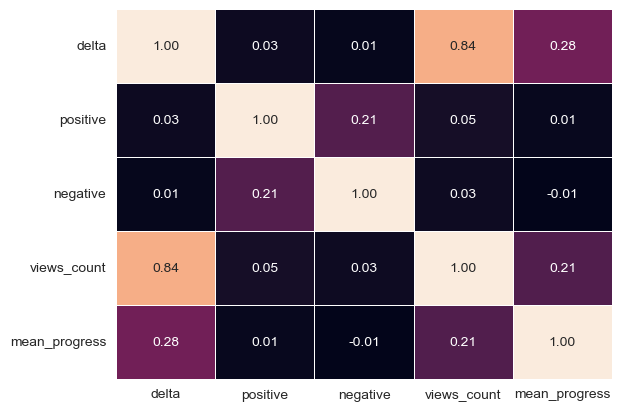

In [140]:
sns.heatmap(df[num_cols].corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

Видим, что views_count(число просмотров) и delta(общая длительность просмотров) сильно скоррелированы, поэтому один признак можно убрать. Убираю delta (общая длительность просмотров в секундах).

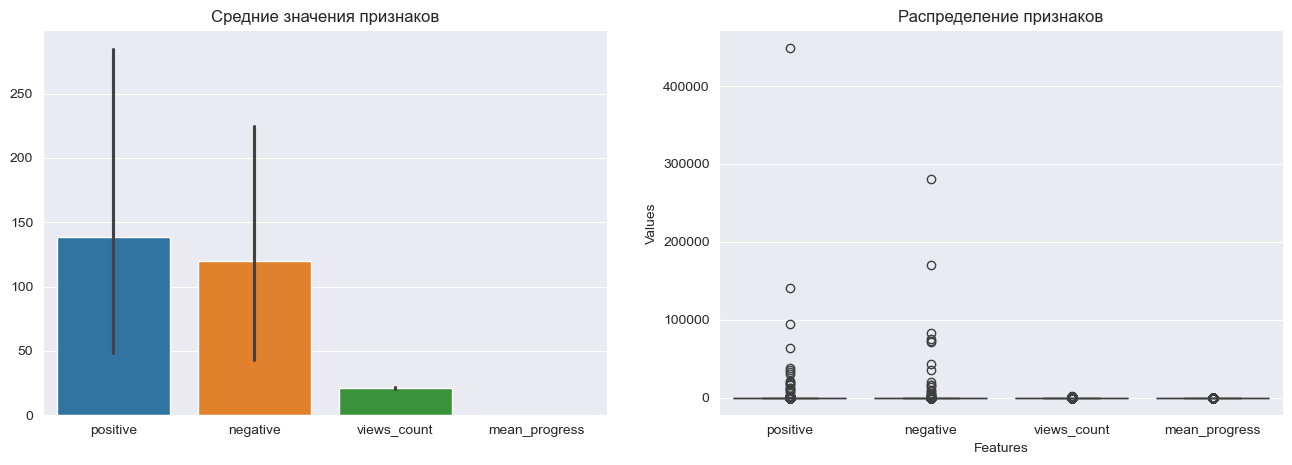

In [141]:
num_cols = num_cols.drop(['delta'])
bar_box_plot(df[num_cols])

Наблюдаем очень большой разброс и большое количество выбросов в числовых признаках. Необходимо сделать нормализацию числовых данных. Стандартизация для k-prototypes не подходит, т.к. Z-score создает отрицательные значения, что усложняет интерпретацию центроидов и может давать артефакты при расчете расстояний

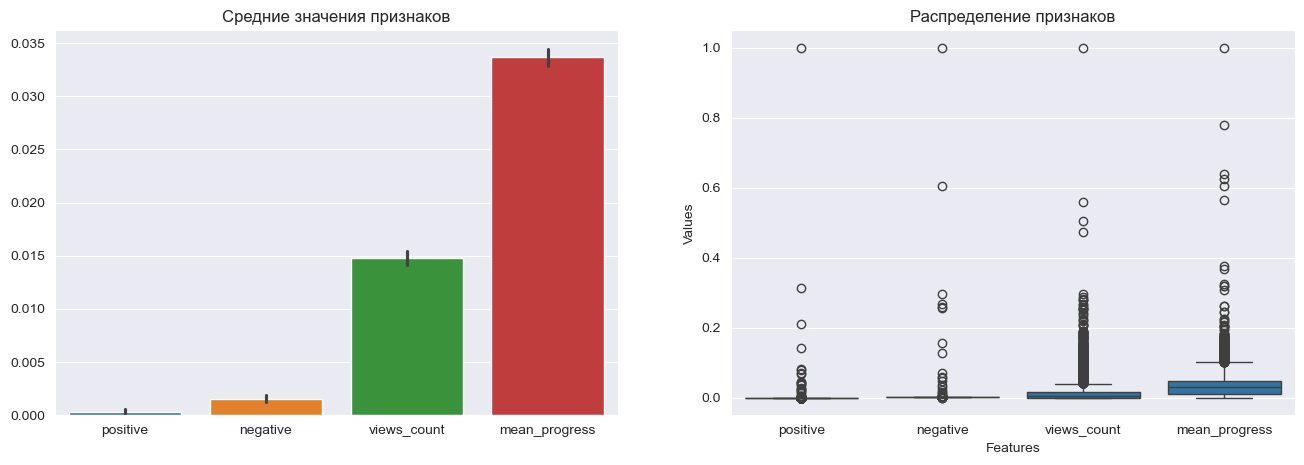

In [142]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
bar_box_plot(df[num_cols])

### Категориальные признаки

In [143]:
df[cat_cols].head()

,profile_is_child,geo,device,genres,hashtags,cls,period,weekdays
0,0,RU,web,various,various,Series,Evening,weekdays
1,0,BY,tv,comedy,С субтитрами для слабослышащих,Series,Evening,weekdays
2,0,RU,web,comedy,various,Series,Evening,weekend
3,1,RU,tv,various,various,Series,Night,weekdays
4,0,DE,mobile,detective,Ведется расследование,Series,Evening,weekend


Смотрим количество уникальных значений в каждой колонке

In [144]:
df[cat_cols].nunique()

profile_is_child     2
geo                 64
device               4
genres              22
hashtags            92
cls                  3
period               5
weekdays             3
dtype: int64

Удаляем самые большие значения - geo и hashtags, так как большое количество категориальных признаков может привести к проблемам с выбором центроидов, переобучению и сложности в интерпретации кластеров


In [145]:
cat_cols = cat_cols.drop(['geo', 'hashtags'])

Построим график распределения кластеров

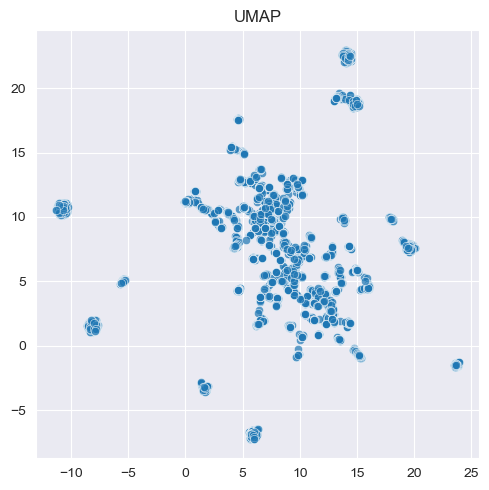

In [146]:
def draw_clusters(dataframe: pd.DataFrame):
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(dataframe)
    reducer = umap.UMAP()
    emb = reducer.fit_transform(encoded)
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=emb[:, 0],
        y=emb[:, 1],
        alpha=0.7
    )
    plt.title('UMAP')
    plt.tight_layout()
    plt.show()
draw_clusters(df[cat_cols])

Видно что кое-где образовываются кластеры, но в основном картина печальная

## Обучение K-modes
Обучим модель k-modes "из коробки" на 10-ти кластерах и посчитаем метрику silhouette_score
Возьмем следующие метрики:
Силуэтный коэффициент (Silhouette Score): Этот коэффициент измеряет, насколько объект похож на свой кластер по сравнению с соседними кластерами. Значение от +1 до -1, где 1 подразумевает, что объект правильно классифицирован, 0 указывает на сопредельные кластеры, а -1 означает, что он был неправильно отнесен к кластеру. Силуэтный коэффициент полезен для оценки и сравнения различных кластеризаций.
Коэффициент Калински-Харабаза (Calinski-Harabasz Index): Этот индекс измеряет соотношение между внутрикластерной дисперсией и межклассовой дисперсией. Более высокие значения этого индекса указывают на более качественные кластеризации.
Индекс Дэвиса-Боулдина (Davies-Bouldin Index): Он измеряет среднее отношение между внутрикластерными расстояниями и межкластерными расстояниями. Более низкие значения индекса указывают на лучшее качество кластеризации.

In [147]:
def scores_calc(dataframe, clrs, metric):
    df_encoded = dataframe.apply(lambda x: x.astype('category').cat.codes)
    distance_matrix = pairwise_distances(df_encoded, metric=metric)
    shi = silhouette_score(distance_matrix, clrs, metric=metric)
    chi = calinski_harabasz_score(distance_matrix, clrs)
    dbi = davies_bouldin_score(distance_matrix, clrs)
    return shi, chi, dbi

X = df[cat_cols].head(500)
km = KModes(n_jobs=-1)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.04810592661529869 
Calinski-Harabasz Score: 30.334351062693298
Davies-Bouldin Score: 2.2543817059000966


Очень низкий показатель Silhouette Score, нормальные результаты начинаются когда s_score > 0.5, а хорошие при s_score > 0.7.
Попробуем найти самые важные признаки и убрать менее значимые. 
Для этого используем библиотеку prince https://maxhalford.github.io/prince/ и класс MCA, работающий с категориальными признаками

In [148]:
cat_data = df[cat_cols].head(300)
mca = MCA(n_components=len(cat_data.columns), n_iter=10, random_state=42, engine='sklearn')
mca = mca.fit(cat_data)
eigenvalues = mca.eigenvalues_
columns = cat_data.columns
importance_df = pd.DataFrame({
    'Feature': columns,
    'Eigenvalue': eigenvalues
}).sort_values(by='Eigenvalue', ascending=False)
importance_df

,Feature,Eigenvalue
0,profile_is_child,0.325873
1,device,0.268766
2,genres,0.226810
3,cls,0.210535
4,period,0.200310
5,weekdays,0.189871


Видим, что cls (фильм или сериал), period (время просмотра - утро, день, вечер, ночь) и weekdays (время просмотра - будни, выходные), которые были созданы, в рейтинге на последних местах. Удалим их

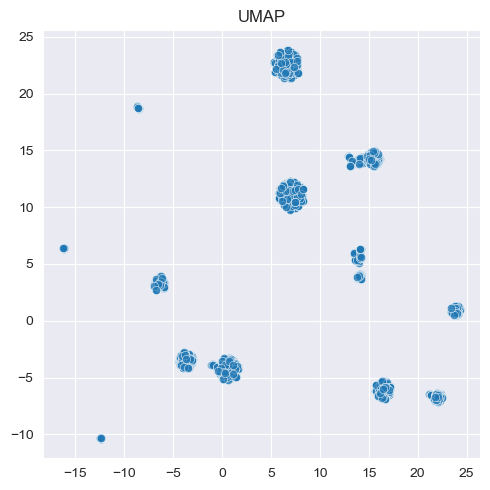

In [149]:
final_cat_cols = cat_cols.drop(['cls', 'period', 'weekdays'])
draw_clusters(df[final_cat_cols])

Видим на визуализации уже вполне отчетливые кластеры. Проведем повторную оценку кластеров

In [150]:
X = df[final_cat_cols].head(500)
km = KModes(n_jobs=-1)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.6003422384398648 
Calinski-Harabasz Score: 222.5708213694636
Davies-Bouldin Score: 0.7269934989249652


Видим, что метрики значительно улучшились
Сделаем оптимизацию гиперпараметра n_clusters

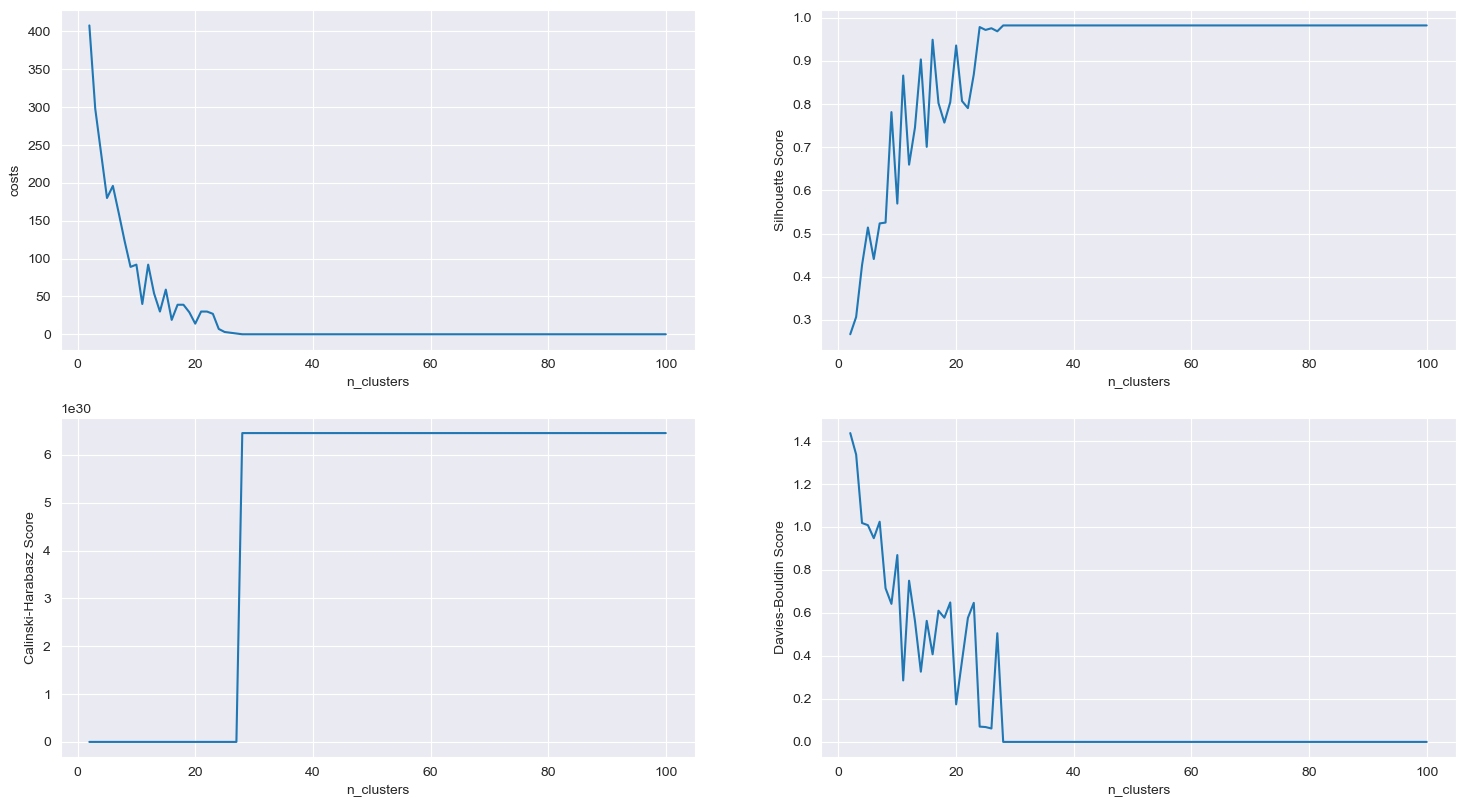

In [151]:
n_clusters = []
costs = []
s_scores =  []
ch_scores = []
db_scores = []
K = range(2, 101)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=2, verbose=0, random_state=42, n_jobs=-1)
    n_clusters.append(k)
    clusters = km.fit_predict(X)
    costs.append(km.cost_)
    metrics = scores_calc(X, clusters, 'hamming')
    s_scores.append(metrics[0])
    ch_scores.append(metrics[1])
    db_scores.append(metrics[2])
    
train_results = pd.DataFrame({'n_clusters':n_clusters, 'costs': costs, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores, 'Davies-Bouldin Score':db_scores})
multiple_graphs(2, 'n_clusters', train_results)

Повторим оптимизацию с помощью библиотеки hyperopt, определим минимальное количество кластеров 

In [152]:
def objective(params):
    n_clrs = int(params['n_clusters'])
    init = params['init']
    model = KModes(n_clusters=n_clrs, init=init, n_init=2, random_state=42)
    clrs = model.fit_predict(X)
    cost = model.cost_
    # штраф за большое количество кластеров
    penalty = 0.01 * n_clrs
    
    ss, chs, dbi = scores_calc(X, clrs, 'hamming')
    return {
        'loss': cost + penalty, 
        'status': 'ok', 
        'n_clusters': n_clrs, 
        'cost': cost, 
        'silhouette': ss,
        'calinski_harabasz': chs,
        'davies_bouldin' :dbi
    }
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 100)),
    'init': hp.choice('init', ['Huang', 'Cao']),
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print(f"Лучшие гиперпараметры:\n{best}")

100%|██████████| 100/100 [00:10<00:00,  9.97trial/s, best loss: 0.28]
Лучшие гиперпараметры:
{'init': 0, 'n_clusters': 26}


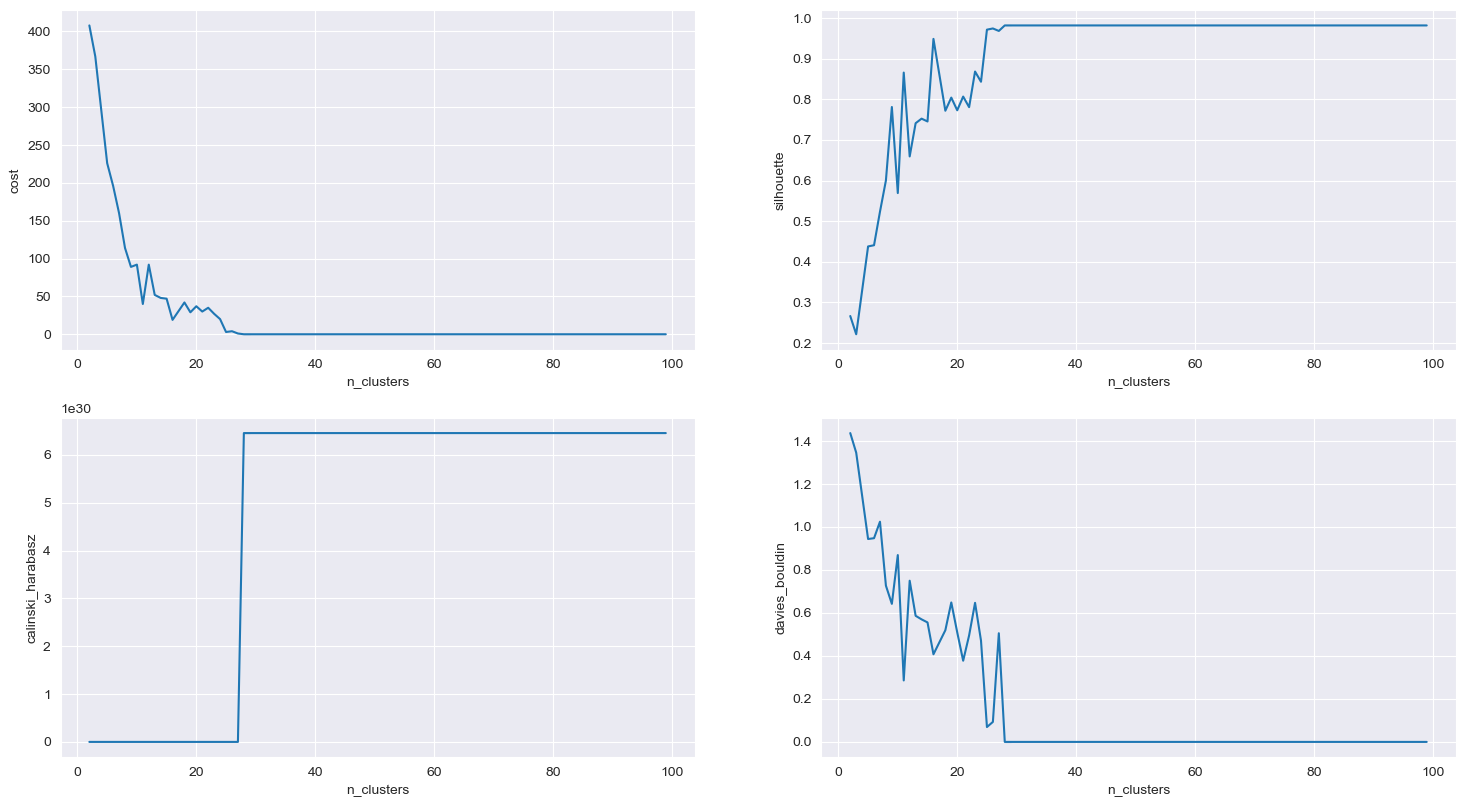

In [153]:
multiple_graphs(2, 'n_clusters', pd.DataFrame(trials.results).sort_values('loss').drop(['status', 'loss'], axis=1))

Минимальное количество кластеров на k-modes - 26. Проведем заново оценку.

In [154]:
km = KModes(n_clusters=26, init='Cao', n_init=5, n_jobs=-1)
clusters = km.fit_predict(X)
scores = scores_calc(X, clusters, 'hamming')
print(f"Silhouette Score: {scores[0]} \nCalinski-Harabasz Score: {scores[1]}\nDavies-Bouldin Score: {scores[2]}")

Silhouette Score: 0.9745387755102041 
Calinski-Harabasz Score: 156114.58970482758
Davies-Bouldin Score: 0.09302111324246409


Метрики отличные. Но попробуем получить меньшее количество кластеров.

## Обучение K-prototypes

In [157]:
combined_cols = cat_cols.append(num_cols)
combined_data = df[combined_cols].head(300)
famd = FAMD(n_components=len(combined_data.columns), n_iter=3, check_input=True, random_state=42, engine='sklearn', handle_unknown="error")
famd = famd.fit(combined_data)
eigenvalues = famd.eigenvalues_
columns = combined_data.columns
importance_combined_df = pd.DataFrame({
    'Feature': columns,
    'Eigenvalue': eigenvalues
}).sort_values(by='Eigenvalue', ascending=False)
importance_combined_df

,Feature,Eigenvalue
0,profile_is_child,5.901856
1,device,4.857688
2,genres,4.117250
3,cls,3.866217
4,period,3.617032
5,weekdays,3.449645
6,positive,3.411537
7,negative,3.199605
8,views_count,3.172937
9,mean_progress,3.037997


In [156]:
combined_data

,profile_is_child,device,genres,cls,period,weekdays,positive,negative,views_count,mean_progress
0,0,web,various,Series,Evening,weekdays,0.000000,0.001142,0.000000,0.104503
1,0,tv,comedy,Series,Evening,weekdays,0.000000,0.001142,0.037091,0.050917
2,0,web,comedy,Series,Evening,weekend,0.000024,0.001156,0.002909,0.025241
3,1,tv,various,Series,Night,weekdays,0.000000,0.001142,0.000000,0.011649
4,0,mobile,detective,Series,Evening,weekend,0.000000,0.001142,0.004364,0.020555
...,...,...,...,...,...,...,...,...,...,...
295,0,tv,drama,Series,Evening,weekdays,0.000045,0.001149,0.010182,0.031226
296,0,tv,comedy,Movie,Evening,weekdays,0.000000,0.001146,0.001455,0.000620
297,0,tv,various,Series,Day,weekend,0.000000,0.001142,0.000000,0.029407
298,0,tv,drama,Series,Evening,weekdays,0.000000,0.001142,0.027636,0.041240


In [56]:
# from sklearn.decomposition import PCA
# 
# pca = PCA(n_components=4)
# principal_components = pca.fit_transform(combined_data)
# explained_variance = pca.explained_variance_ratio_
# 
# print("Explained Variance Ratios:")
# print(explained_variance)



In [57]:
# km = KModes(n_clusters=15, init='Huang', n_init=5, n_jobs=-1)
# clusters = km.fit_predict(df[cat_cols])
# df['k_modes_clusters'] = clusters
# df_encoded = df[cat_cols].apply(lambda x: x.astype('category').cat.codes)
# distance_matrix = pairwise_distances(df_encoded, metric='hamming')
# s_score = silhouette_score(distance_matrix, clusters, metric='hamming')
# print(f"Silhouette Score: {s_score:.3f}")

In [58]:
# s_score = silhouette_score(gower_matrix(df[cat_cols]), clusters, metric="hamming")

In [59]:
# s_score

In [60]:
# X = pd.concat([df[num_cols].drop(['delta', 'positive', 'negative', ], axis=1), df[['cls', 'period', 'genres']]], axis=1)
X = pd.concat([df[num_cols].drop('mean_progress', axis=1), df[final_cat_cols]], axis=1)
print(X.head())
X_train = X.head(400)
n_clusters = []
s_scores =  []
ch_scores = []
costs = []

for k in range(2, 70):
    try:
        k_proto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_init=3, n_jobs=-1)
        clusters = k_proto.fit_predict(X_train, categorical=[3,4,5])
        Xg = gower_matrix(X_train)
        s_scores.append(silhouette_score(Xg, clusters, metric="precomputed"))
        ch_scores.append(calinski_harabasz_score(Xg, clusters))

        costs.append(k_proto.cost_)
        n_clusters.append(k)
    except Exception as e:
        print(f'{e} Number of clusters {k}')
        break

   positive  negative  views_count  profile_is_child  device     genres
0  0.000000  0.001142     0.000000                 0     web    various
1  0.000000  0.001142     0.037091                 0      tv     comedy
2  0.000024  0.001156     0.002909                 0     web     comedy
3  0.000000  0.001142     0.000000                 1      tv    various
4  0.000000  0.001142     0.004364                 0  mobile  detective
Clustering algorithm could not initialize. Consider assigning the initial clusters manually. Number of clusters 28


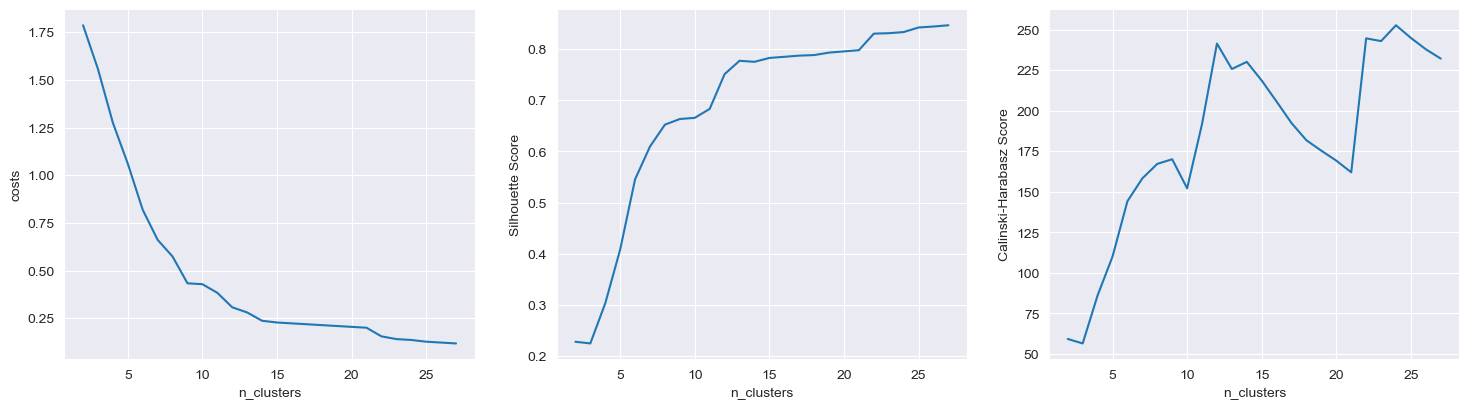

In [61]:
train_results = pd.DataFrame({'n_clusters':n_clusters, 'costs': costs, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores})
multiple_graphs(3, 'n_clusters', train_results)


In [62]:
k_proto = KPrototypes(n_clusters=50, init='Cao', random_state=42, n_jobs=-1)
clusters = k_proto.fit_predict(X, categorical=[3,4,5])
s_score = silhouette_score(gower_matrix(X), clusters, metric="precomputed")
ch_score = calinski_harabasz_score(gower_matrix(X), clusters)
print(f"Silhouette Score: {s_score}")
print(f"Calinski-Harabasz Score: {ch_score}")

Silhouette Score: 0.8811097145080566
Calinski-Harabasz Score: 7652.376807240582
